In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from datasets import load_dataset
from transformers import AutoTokenizer
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import json

import torch
torch.cuda.empty_cache()


c:\Users\Revalda Putawara\.conda\envs\mbgsentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
files = {
    "train": r"dataset/train/train.csv", 
    "eval": r"dataset/train/eval.csv", 
    "test": r"dataset/train/test.csv",
}

dataset = load_dataset('csv', data_files=files)

In [4]:
model_check = AutoModelForSequenceClassification.from_pretrained("model_large")
tokenizer_check = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p2")
trainer_check = Trainer(model=model_check, tokenizer=tokenizer_check)

C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_35444\989419479.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_check = Trainer(model=model_check, tokenizer=tokenizer_check)


In [5]:
def tokenize_function(text):
    return tokenizer_check(text["text"], padding='max_length', max_length=256)

In [6]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 95/95 [00:00<00:00, 2051.70 examples/s]


In [7]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

In [8]:
test_dataset = tokenized_datasets["test"]

prediction = trainer_check.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [11]:
df_test=pd.read_csv(r"dataset/train/test.csv")

In [12]:
actual_label = df_test['label']

In [15]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.98      0.89      0.93        46
      Netral       0.64      0.84      0.73        19
     Positif       0.89      0.83      0.86        30

    accuracy                           0.86        95
   macro avg       0.84      0.86      0.84        95
weighted avg       0.88      0.86      0.87        95



In [14]:
prediction

array([1, 2, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 2, 0,
       2, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1,
       2, 1, 1, 2, 0, 1, 0])

In [17]:
f1_metric = evaluate.load("f1")

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return f1_metric.compute(predictions=predictions, references=labels)

In [18]:
f1_metric.compute(predictions=prediction, references=actual_label, average="weighted")

{'f1': 0.8574327668701535}

In [29]:
prediction_ayamerushia = pd.read_csv(r"result_prediction/prediction_ayamerushia_250206-181742.csv")["0"].tolist()
prediction_ayamerushia = np.array(prediction_ayamerushia)

In [30]:
f1_metric.compute(predictions=prediction_ayamerushia, references=actual_label, average="weighted")

{'f1': 0.8}

In [39]:
with open(r"result_model/result_ayamerushia_250206-181742.json") as json_data:
    ayamerushia_history = json.load(json_data)
    json_data.close()

In [40]:
with open(r"result_model/result_cahya_250206-172807.json") as json_data:
    cahya_history = json.load(json_data)
    json_data.close()

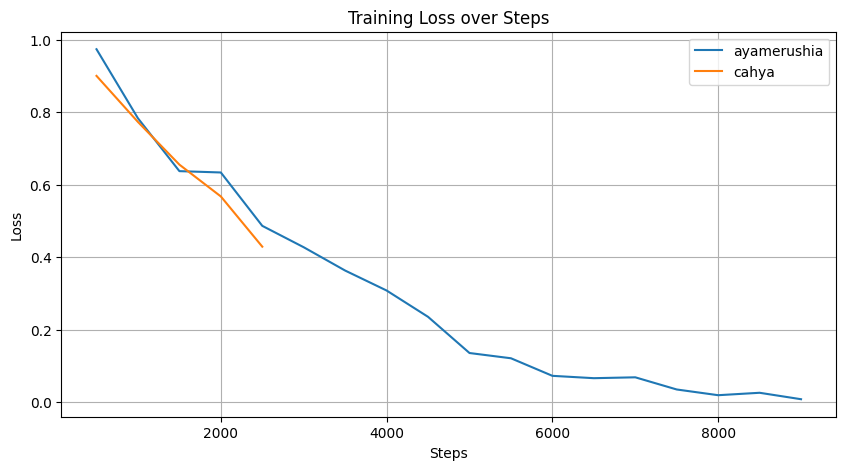

In [44]:
steps_ayamerushia = []
losses_ayamerushia = []
steps_cahya = []
losses_cahya = []

for log in ayamerushia_history["trainer_history"]:
    if "loss" in log: 
        steps_ayamerushia.append(log["step"])
        losses_ayamerushia.append(log["loss"])

for log in cahya_history["trainer_history"]:
    if "loss" in log: 
        steps_cahya.append(log["step"])
        losses_cahya.append(log["loss"])

plt.figure(figsize=(10, 5))
plt.plot(steps_ayamerushia, losses_ayamerushia, label="ayamerushia")
plt.plot(steps_cahya, losses_cahya, label="cahya")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()